# check mask

In [ ]:
def csv_to_tensor(filename, axis=0):
    matrix = np.loadtxt(filename, delimiter=',')
    return tensor

filename = 'imgs/attention_mask_4patchhes.csv'
pacthes = csv_to_tensor(filename)

# llama.cpp image layout


In [8]:
nx = 5
ny = 3
for k in range(3):
    print(f'channel: {k}')
    for y in range(ny):
        print(f'row {y}:', end=' ')
        for x in range(nx):
            print(f"{3*(y*nx + x) + k: 3d}", end=' ')
        print()
    print('-'*30)
    

channel: 0
row 0:   0   3   6   9  12 
row 1:  15  18  21  24  27 
row 2:  30  33  36  39  42 
------------------------------
channel: 1
row 0:   1   4   7  10  13 
row 1:  16  19  22  25  28 
row 2:  31  34  37  40  43 
------------------------------
channel: 2
row 0:   2   5   8  11  14 
row 1:  17  20  23  26  29 
row 2:  32  35  38  41  44 
------------------------------


# Image Resize

In [1]:
from omegaconf import OmegaConf
from open_flamingo.train.any_res_data_utils import process_images
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, Lambda
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

cfg = dict(
    model_family = 'kosmos',
    lm_path = 'microsoft/Phi-3-mini-4k-instruct',
    # vision_encoder_path = 'ViT-H-14-378-quickgelu',
    # vision_encoder_pretrained = 'dfn5b',
    vision_encoder_path = 'google/siglip-so400m-patch14-384',
    vision_encoder_pretrained = 'google',
    num_vision_tokens = 128,
    image_aspect_ratio = 'anyres',
    anyres_patch_sampling = True,
    anyres_grids=[[1,2],[2,1],[2,2],[3,1],[1,3]],
    ckpt_pth = '/export/share/manli_shu/models/open-flamingo-dev/anyres_ablation_HFSiglip_patch128-kosmos_non_instruct-phi3_4k_instruct_nq128_pre_V3_5-llava_1p6_ocrmathmix_v4-8x8-ckpt2/checkpoint_0.pt',
)
cfg = OmegaConf.create(cfg)
n_px = 384
image_processor = Compose([
        Resize((n_px, n_px), interpolation=InterpolationMode.BICUBIC, antialias=True),
        Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
image_proc = partial(process_images, image_processor=image_processor, model_cfg=cfg)
base_img_size = image_processor.transforms[0].size[0]
anyres_grids = []
for (m,n) in cfg.anyres_grids:
    anyres_grids.append([base_img_size*m, base_img_size*n])
cfg.anyres_grids = anyres_grids

In [2]:
image_aspect_ratio = cfg.image_aspect_ratio
print(f"image_aspect_ratio: {image_aspect_ratio}")
anyres_grids = cfg.anyres_grids
print(f"anyres_grids: {anyres_grids}")

image_aspect_ratio: anyres
anyres_grids: [[384, 768], [768, 384], [768, 768], [1152, 384], [384, 1152]]


In [3]:
img_dir = "./imgs"
image_path_1 = f'{img_dir}/image-1d100e9-1.jpg'
image_path_2 = f'{img_dir}/image-1d100e9.jpg'
image_1 = Image.open(image_path_1).convert('RGB')
image_2 = Image.open(image_path_2).convert('RGB')
images = [image_1, image_2]
image_size = [image_1.size, image_2.size]
image_size = [image_size]
vision_x = [image_proc([img]) for img in images]
vision_x = [vision_x]

In [4]:
print(type(image_processor.transforms[0]))
image_processor.transforms

<class 'torchvision.transforms.transforms.Resize'>


[Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=True),
 Lambda(),
 ToTensor(),
 Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

In [5]:
import numpy as np
np.asarray(image_processor.transforms[0](image_2))[:5, :10, 0]

array([[217, 212, 211, 213, 213, 210, 210, 210, 213, 214],
       [213, 211, 212, 212, 209, 212, 211, 210, 210, 211],
       [213, 211, 211, 212, 210, 213, 212, 211, 210, 210],
       [215, 211, 209, 212, 212, 211, 210, 210, 210, 210],
       [211, 208, 209, 211, 210, 211, 211, 211, 211, 211]], dtype=uint8)

In [58]:
reference = vision_x[0][1].squeeze().detach().cpu().numpy()
reference.shape

(5, 3, 384, 384)

In [59]:
def csv_to_tensor(filename, axis=0):
    matrix = np.loadtxt(filename, delimiter=',')
    mc_0 = matrix[:384, :]
    mc_1 = matrix[384:384+384, :]
    mc_2 = matrix[384+384:, :]
    tensor = np.stack([mc_0, mc_1, mc_2], axis=axis)
    return tensor

filename = 'imgs/image_res_{}.csv'
pacthes = [csv_to_tensor(filename.format(i)) for i in range(reference.shape[0])]

In [50]:

diff = np.abs(pacthes - reference)
print("max diff:{:3e} | min diff:{:3e} | mean diff:{:3e} | median diff:{:3e}".format(
    np.max(diff), np.min(diff), np.mean(diff), np.median(diff)))
# for patch_idx in range(len(pacthes)):
#     vis = diff[patch_idx]
#     vis_flat = np.concatenate([vis[0], vis[1], vis[2]], axis=1)
#     plt.figure(figsize=(9, 3))
#     sns.heatmap(vis_flat, cmap='coolwarm', center=1e-3)
#     plt.title(f'Difference for patch {patch_idx}')
#     plt.show()

max diff:6.039216e-01 | min diff:0.000000e+00 | mean diff:5.627964e-03 | median diff:2.031174e-07


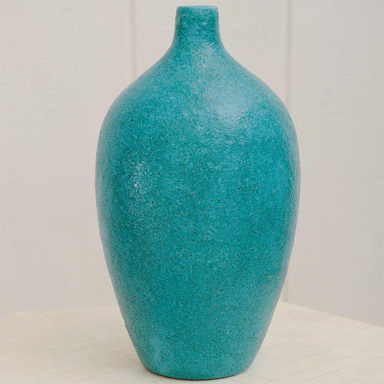

In [65]:
reference = image_2.resize((384, 384), resample=Image.BICUBIC)
reference

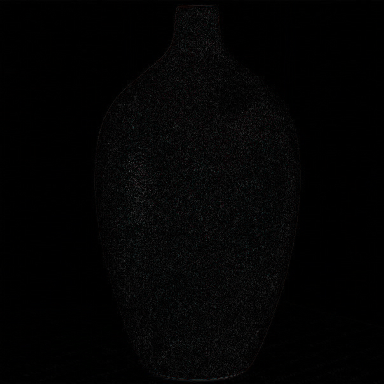

In [107]:
diff = np.abs(csv_to_tensor('imgs/image_original_resize.csv', axis=2) - np.array(reference)).astype(np.uint8)
diff.shape, diff.dtype
Image.fromarray(np.uint8(diff), 'RGB')
Image.fromarray(diff)

# diff = np.abs(csv_to_tensor('imgs/image_original_resize.csv', axis=2) - np.array(reference)).astype(np.uint8)
# Image.fromarray(np.uint8(diff), 'RGB')
# Image.fromarray(diff)

# diff = csv_to_tensor('imgs/image_original_resize.csv', axis=2) - np.array(reference)
# vis_flat = np.concatenate([diff[:,:,0], diff[:,:,1], diff[:,:,2]], axis=1)
# plt.figure(figsize=(9, 3))
# sns.heatmap(vis_flat, cmap='coolwarm', center=1e-3)
# plt.show()

# Model surgery

In [3]:
from open_flamingo import create_model_and_transforms
from omegaconf import OmegaConfd
import torch

In [5]:
cfg = dict(
    model_family = 'kosmos',
    lm_path = 'microsoft/Phi-3-mini-4k-instruct',
    # vision_encoder_path = 'ViT-H-14-378-quickgelu',
    # vision_encoder_pretrained = 'dfn5b',
    vision_encoder_path = 'google/siglip-so400m-patch14-384',
    vision_encoder_pretrained = 'google',
    num_vision_tokens = 128,
    image_aspect_ratio = 'anyres',
    anyres_patch_sampling = True,
    anyres_grids=[[1,2],[2,1],[2,2],[3,1],[1,3]],
    ckpt_pth = '/export/share/manli_shu/models/open-flamingo-dev/anyres_ablation_HFSiglip_patch128-kosmos_non_instruct-phi3_4k_instruct_nq128_pre_V3_5-llava_1p6_ocrmathmix_v4-8x8-ckpt2/checkpoint_0.pt',
)
cfg = OmegaConf.create(cfg)
if cfg.model_family in ['kosmos-instruct', 'kosmos', 'llava']:
    additional_kwargs = {
        "image_aspect_ratio": cfg.image_aspect_ratio,
        }
    if cfg.model_family in ['kosmos-instruct', 'kosmos']:
        additional_kwargs.update({
            "num_vision_tokens": cfg.num_vision_tokens,
            "anyres_patch_sampling": cfg.anyres_patch_sampling,
        })
print(additional_kwargs)

{'image_aspect_ratio': 'anyres', 'num_vision_tokens': 128, 'anyres_patch_sampling': True}


In [46]:
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path=cfg.vision_encoder_path,
    clip_vision_encoder_pretrained=cfg.vision_encoder_pretrained,
    lang_model_path=cfg.lm_path,
    tokenizer_path=cfg.lm_path,
    model_family=cfg.model_family,
    **additional_kwargs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

kosmos model initialized with 3,931,031,619 trainable parameters
==========Trainable Parameters
Vision encoder: 0 trainable parameters
Vision tokenizer: 109,901,568 trainable parameters
Language model: 3,821,130,051 trainable parameters
==========Total Parameters
Vision encoder: 428,225,600 parameters
Vision tokenizer: 109,901,568 parameters
Language model: 3,821,130,051 parameters


In [47]:
ckpt = torch.load(cfg.ckpt_pth)["model_state_dict"]

In [51]:
model.vision_tokenizer

PerceiverResampler(
  (projection): Linear(in_features=1152, out_features=3072, bias=True)
  (layers): ModuleList(
    (0-5): 6 x ModuleList(
      (0): PerceiverAttention(
        (norm_media): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
        (norm_latents): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
        (to_q): Linear(in_features=1152, out_features=1536, bias=False)
        (to_kv): Linear(in_features=1152, out_features=3072, bias=False)
        (to_out): Linear(in_features=1536, out_features=1152, bias=False)
      )
      (1): Sequential(
        (0): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=1152, out_features=4608, bias=False)
        (2): GELU(approximate='none')
        (3): Linear(in_features=4608, out_features=1152, bias=False)
      )
    )
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
)

In [55]:
image_processor

Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=True)
    Lambda()
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [39]:
model.vision_encoder.config.save_pretrained('/export/share/yutong/xgenmm/llamacpp_wd/siglip_kosmos_phi3_4k_instruct/vit_config')

In [25]:
image_processor

Compose(
    Resize(size=(384, 384), interpolation=bicubic, max_size=None, antialias=True)
    Lambda()
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [3]:
from transformers.models.siglip.modeling_siglip import SiglipVisionTransformer, SiglipVisionConfig
import json
import torch
with open('/export/share/yutong/xgenmm/llamacpp_wd/siglip_kosmos_phi3_4k_instruct/vision_encoder/config.json', 'r') as f:
    vision_config = json.load(f)
vision_config = SiglipVisionConfig(**vision_config)
vision_encoder = SiglipVisionTransformer(vision_config)
vit_ckpt = torch.load('/export/share/yutong/xgenmm/llamacpp_wd/siglip_kosmos_phi3_4k_instruct/vision_encoder/xgenmm.vision_encoder')
vision_encoder.load_state_dict(vit_ckpt, strict=True)

<All keys matched successfully>

In [5]:
state_dict = vision_encoder.state_dict()

In [6]:
state_dict.keys()

odict_keys(['embeddings.patch_embedding.weight', 'embeddings.patch_embedding.bias', 'embeddings.position_embedding.weight', 'encoder.layers.0.self_attn.k_proj.weight', 'encoder.layers.0.self_attn.k_proj.bias', 'encoder.layers.0.self_attn.v_proj.weight', 'encoder.layers.0.self_attn.v_proj.bias', 'encoder.layers.0.self_attn.q_proj.weight', 'encoder.layers.0.self_attn.q_proj.bias', 'encoder.layers.0.self_attn.out_proj.weight', 'encoder.layers.0.self_attn.out_proj.bias', 'encoder.layers.0.layer_norm1.weight', 'encoder.layers.0.layer_norm1.bias', 'encoder.layers.0.mlp.fc1.weight', 'encoder.layers.0.mlp.fc1.bias', 'encoder.layers.0.mlp.fc2.weight', 'encoder.layers.0.mlp.fc2.bias', 'encoder.layers.0.layer_norm2.weight', 'encoder.layers.0.layer_norm2.bias', 'encoder.layers.1.self_attn.k_proj.weight', 'encoder.layers.1.self_attn.k_proj.bias', 'encoder.layers.1.self_attn.v_proj.weight', 'encoder.layers.1.self_attn.v_proj.bias', 'encoder.layers.1.self_attn.q_proj.weight', 'encoder.layers.1.self_a

In [8]:
state_dict['embeddings.position_embedding.weight'].shape

torch.Size([729, 1152])

In [9]:
state_dict['embeddings.position_embedding.weight'].unsqueeze(0).shape

torch.Size([1, 729, 1152])

In [10]:
projector = torch.load('/export/share/yutong/xgenmm/llamacpp_wd/siglip_kosmos_phi3_4k_instruct/xgenmm.projector')

In [11]:
for k in projector.keys():
    print(k)

latents
projection.weight
projection.bias
layers.0.0.norm_media.weight
layers.0.0.norm_media.bias
layers.0.0.norm_latents.weight
layers.0.0.norm_latents.bias
layers.0.0.to_q.weight
layers.0.0.to_kv.weight
layers.0.0.to_out.weight
layers.0.1.0.weight
layers.0.1.0.bias
layers.0.1.1.weight
layers.0.1.3.weight
layers.1.0.norm_media.weight
layers.1.0.norm_media.bias
layers.1.0.norm_latents.weight
layers.1.0.norm_latents.bias
layers.1.0.to_q.weight
layers.1.0.to_kv.weight
layers.1.0.to_out.weight
layers.1.1.0.weight
layers.1.1.0.bias
layers.1.1.1.weight
layers.1.1.3.weight
layers.2.0.norm_media.weight
layers.2.0.norm_media.bias
layers.2.0.norm_latents.weight
layers.2.0.norm_latents.bias
layers.2.0.to_q.weight
layers.2.0.to_kv.weight
layers.2.0.to_out.weight
layers.2.1.0.weight
layers.2.1.0.bias
layers.2.1.1.weight
layers.2.1.3.weight
layers.3.0.norm_media.weight
layers.3.0.norm_media.bias
layers.3.0.norm_latents.weight
layers.3.0.norm_latents.bias
layers.3.0.to_q.weight
layers.3.0.to_kv.weig

In [12]:
to_q = projector['layers.0.0.to_q.weight']
to_kv= projector['layers.0.0.to_kv.weight']
to_o = projector['layers.0.0.to_out.weight']

In [13]:
to_q.shape, to_kv.shape, to_o.shape

(torch.Size([1536, 1152]), torch.Size([3072, 1152]), torch.Size([1152, 1536]))

In [14]:
import re
re.sub("attn.in_proj_", "attn.q.", 'attn.in_proj_weight')

'attn.q.weight'